# Set Up

In [ ]:
import pandas as pd
import numpy as np
import seaborn as snsa
import matplotlib.pyplot as plt
import os

## Importing datasets

In [ ]:
if not os.path.exists('MacroDataUS'):
    !git clone https://github.com/raidahmorshed/MacroDataUS

durables = pd.read_csv('MacroDataUS/Durable Goods (Q) SA - 1948-2019.csv')
gdp = pd.read_csv("MacroDataUS/GDP (Q) SA 1948-2019.csv")
gpdi = pd.read_csv("MacroDataUS/GPDI (Q) SA 1948-2019.csv")
nondurables = pd.read_csv("MacroDataUS/Nondurable Goods (Q) SA - 1948-2019.csv")
hours_worked = pd.read_csv("MacroDataUS/Nonfarm Business Sector- Hours Worked (Q) SA 1948-2019.csv")
output = pd.read_csv("MacroDataUS/Nonfarm Business Sector- Labor Productivity Output per Hour (Q) SA 1948-2019.csv")
services = pd.read_csv("MacroDataUS/Personal Consumption Expenditures- Services (Q) SA 1948-2019.csv")
tfp = pd.read_csv("MacroDataUS/Cleaned TFP (Q) SA 1948-2019.csv")
population = pd.read_csv("MacroDataUS/Population (Q) SA 1948-2019.csv")
deflator = pd.read_csv("MacroDataUS/Price Deflator (Q) SA 1948-2019.csv")

print("All files imported!")

All files imported!


## Cleaning datasets

In [ ]:
# Consistency check

everything = [durables, gdp, gpdi, nondurables, hours_worked, output, services, tfp, population, deflator]

def data_consistency(everything):
    all_columns = []

    # Check if all of them have a DATE column
    for each_dataset in everything:
      for col in each_dataset.columns:
        if col == "DATE":
          all_columns.append(col)
        else:
          pass
    if len(everything) == len(all_columns):
        print("All datasets have a DATE column!")
    else:
        print("DATE column not there!")

data_consistency(everything)

DATE column not there!


In [ ]:
# Making the date column names consistent

def date_consistency(everything):
    for each_dataset in everything:
      for col in each_dataset.columns:
        if col != "DATE":
          each_dataset.rename(columns={'date': "DATE"}, inplace=True)
        else:
          pass

date_consistency(everything)

# Run the consistency check again

data_consistency(everything)

All datasets have a DATE column!


In [ ]:
# Defining consumption and investment and adding them to list of datasets

# Consumption
nondurables["consumption"] = nondurables["PCND"] + services["PCESV"]
consumption = nondurables[["DATE","consumption"]].copy()
nondurables = nondurables.drop(columns="consumption")

# Investment
durables["investment"] = durables['PCDG'] + gpdi['GPDI']
investment = durables[["DATE","investment"]].copy()
durables = durables.drop(columns="investment")

everything = [consumption, investment, durables, gdp, gpdi, nondurables, hours_worked, output, services, tfp]
print(len(everything))

10


# HP Filter

## Taking real per capita values

In [ ]:
# Taking the logs and per capita

population_log = np.log(population["B230RC0Q173SBEA"])

column_mappings = [
    (durables, 'PCDG', 'log_durables', 'log_durables_per_capita'),
    (hours_worked, 'HOANBS', 'log_hours_worked', 'log_hours_worked_per_capita'),
    (gdp, 'GDP', 'log_gdp', 'log_gdp_per_capita'),
    (gpdi, 'GPDI', 'log_gpdi', 'log_gpdi_per_capita'),
    (nondurables, 'PCND', 'log_nondurables', 'log_nondurables_per_capita'),
    (output, 'OPHNFB', 'log_labor_productivity', 'log_labor_productivity_per_capita'),
    (services, 'PCESV', 'log_services', 'log_services_per_capita'),
    (tfp, 'dtfp_util', 'log_tfp', 'log_tfp_per_capita'),
    (consumption, "consumption", "log_consumption", 'log_consumption_per_capita'),
    (investment, "investment", "log_investment", "log_investment_per_capita")
]

def log_and_per_capita(everything, column_mappings):
    for variable, source_column, log_column, real_per_capira_column in column_mappings:
      variable[log_column] = np.log(variable[source_column])
      variable[real_per_capira_column] = variable[log_column]/population_log
    number_of_variables = len(column_mappings)
    if len(everything) == number_of_variables:
      print("All datasets have been transformed!")

log_and_per_capita(everything, column_mappings)

All datasets have been transformed!


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Applying the HP filter

In [ ]:
# Installing and applying the HP filter

from statsmodels.tsa.filters.hp_filter import hpfilter

def hp_filter(column_map):
    for variable, source_column, log_column, real_per_capira_column in column_mappings:
         cycle, trend = hpfilter(variable[real_per_capira_column], lamb=1600)
         variable['trend'] = trend
         variable['cycle'] = cycle
    print(f"HP filter applied to {len(column_mappings)} variables!")

hp_filter(column_mappings)

HP filter applied to 10 variables!


## Figures

<Figure size 640x480 with 0 Axes>

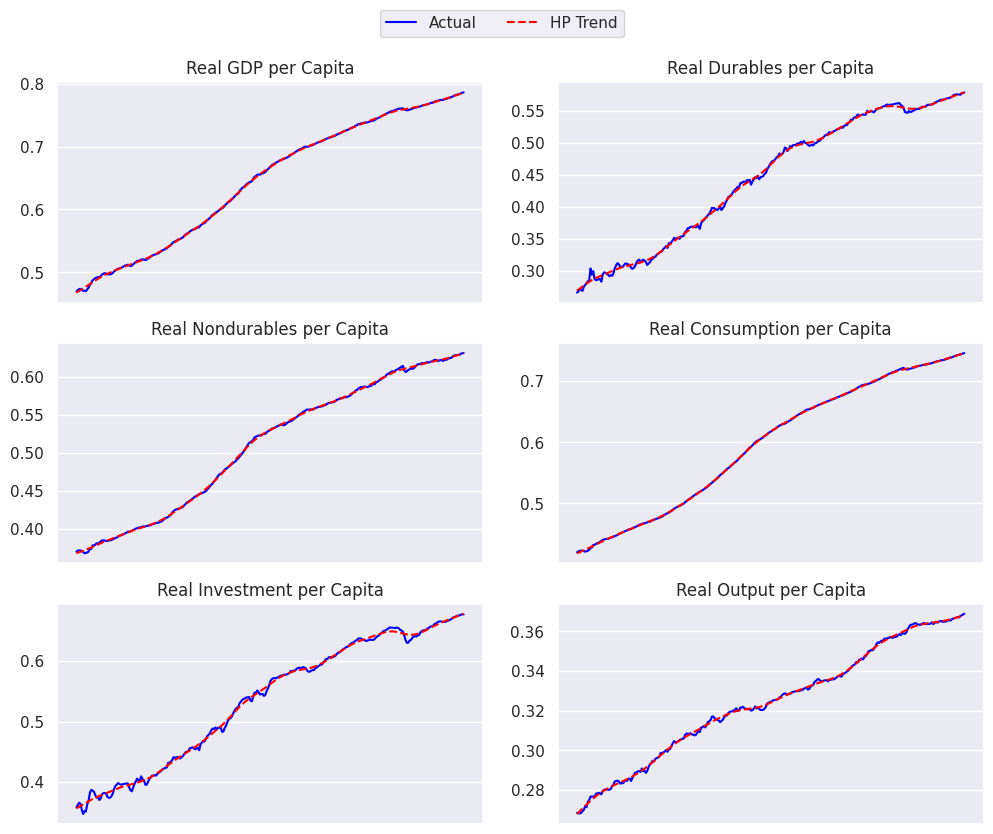

In [ ]:
# Plotting the HP filters

sns.set_theme(style="darkgrid")
sns.set_context(rc={"grid.linewidth": 1})
sns.despine()

fig = plt.figure(figsize=(10, 8))

column_mappings_2 = [
    (gdp, 'DATE', 'log_gdp_per_capita', 'trend', 'cycle'),
    (durables, 'DATE', 'log_durables_per_capita', 'trend', 'cycle'),
    (nondurables, 'DATE', 'log_nondurables_per_capita', 'trend', 'cycle'),
    (consumption, 'DATE', 'log_consumption_per_capita', 'trend', 'cycle'),
    (investment, 'DATE', "log_investment_per_capita", 'trend', 'cycle'),
    (output, 'DATE', 'log_labor_productivity_per_capita', 'trend', 'cycle')
]

variable_names = ['GDP', 'Durables', 'Nondurables', 'Consumption', 'Investment', 'Output']
counter = 0

def plot_graphs(column_mappings_2):
    for (variable, date, real_per_capita_value, hp_trend, hp_cycle) in column_mappings_2:
        global counter
        counter += 1
        ax = plt.subplot(3, 2, counter)
        plt.plot(variable[date], variable[real_per_capita_value], label = 'Actual', color='blue')
        plt.plot(variable[date], variable[hp_trend], label = 'HP Trend', color='red', linestyle='--')
        plt.title(f"Real {variable_names[counter-1]} per Capita")
        ax.set_xticks([])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))
    plt.tight_layout()
    plt.show()

plot_graphs(column_mappings_2)

# Question 1 answers

## Volatility comparisons

In [ ]:
# Calculating volatility

volatility_gdp = gdp['cycle'].std()
volatility_nondurables = nondurables['cycle'].std()
volatility_durables = durables['cycle'].std()
volatility_investment = investment['cycle'].std()
volatility_hours_worked = hours_worked['cycle'].std()

volatilities = {
    "nondurables": volatility_nondurables,
    "durables": volatility_durables,
    "investment": volatility_investment,
    "hours worked": volatility_hours_worked,
    "GDP": volatility_gdp
}

for key, value in volatilities.items():
    print(f"The standard deviation of {key} is {value}")

The standard deviation of nondurables is 0.0014970394159493682
The standard deviation of durables is 0.003502082916630235
The standard deviation of investment is 0.004786473952555474
The standard deviation of hours worked is 0.0015322337974788848
The standard deviation of GDP is 0.001400746067678771


In [ ]:
# Compare volatility

def volatility_comparison(volatilities):
    for variable, volatility in volatilities.items():
        if variable != "GDP":
            if abs(volatility) < 1.1 * volatility_gdp:
                print(f"Volatility of {variable} is similar to GDP")
            else:
                print(f"Volatility of {variable} is higher than GDP")
        else:
          pass

volatility_comparison(volatilities)

Volatility of nondurables is similar to GDP
Volatility of durables is higher than GDP
Volatility of investment is higher than GDP
Volatility of hours worked is similar to GDP


## Correlation comparisons

In [ ]:
# Find correlations

durables_corr = durables['cycle'].corr(gdp['cycle'])
nondurables_corr = nondurables['cycle'].corr(gdp['cycle'])
investment_corr = investment['cycle'].corr(gdp['cycle'])
hours_worked_corr = hours_worked['cycle'].corr(gdp['cycle'])

correlations = {
    "nondurables": nondurables_corr,
    "durables": durables_corr,
    "investment": investment_corr,
    "hours worked": hours_worked_corr,
}

correlations

{'nondurables': 0.690872609263411,
 'durables': 0.3796540671505247,
 'investment': 0.7410599702152093,
 'hours worked': 0.811308074638423}

## The Great Moderation

In [ ]:
# Define the periods
gdp_pre_1983 = gdp[gdp['DATE'] < '1/1/83'].copy()
gdp_post_1983 = gdp[gdp['DATE'] >= '1/1/83'].copy()

volatility_pre_1983 = gdp_pre_1983['cycle'].std()
volatility_post_1983 = gdp_post_1983['cycle'].std()

# Reasons for volatility difference

The_Great_Moderation = {
    "1. Improved monetary policy: ": "Central banks targetted inflation management",
    "2. Economic structural changes: ": "Decline in manufacturing and rise in services sector",
    "3. Improved inventory management: ": "Better stock management meant less volatile production"
}

print(f"Pre-1983 volatility was much higher at {volatility_pre_1983} compared to {volatility_post_1983} post-1983. \n \nThis reduction in volatility, called the Great Moderation, was due to a number of reasons:")

for key, value in The_Great_Moderation.items():
    print(key, value)

Pre-1983 volatility was much higher at 0.0015666409179171108 compared to 0.0013620275099774154 post-1983. 
 
This reduction in volatility, called the Great Moderation, was due to a number of reasons:
1. Improved monetary policy:  Central banks targetted inflation management
2. Economic structural changes:  Decline in manufacturing and rise in services sector
3. Improved inventory management:  Better stock management meant less volatile production
